<a href="https://colab.research.google.com/github/leejunghyunA/deeplearning-_study/blob/main/mulclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import datasets,transforms
import matplotlib.pyplot as plt

## 구글 드라이브와 연동 (코랩 새로 켤때마다 지워지기 땜에)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 구글 GPU 좀 써보자

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [ ]:
torch.cuda.is_available()

True

## train_DS와 test_DS 구경

In [ ]:
# 데이터 다운
transform = transforms.ToTensor() # tensor로 변경
train_DS = datasets.MNIST(root = '/content/drive/MyDrive/파이토치 학습/data', train = True, download = True, transform = transform) # transform : 데이터를 위에서 지정한 텐서형태로 변경
test_DS = datasets.MNIST(root = '/content/drive/MyDrive/파이토치 학습/data', train = False, download = True, transform = transform) # transform : 데이터를 위에서 지정한 텐서형태로 변경


In [ ]:
# 데이터 확인 

print(train_DS)
print(test_DS)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/파이토치 학습/data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/파이토치 학습/data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [ ]:
train_DS.classes # . 뒤에서 탭 하면 이것저것 볼 수 있는 게 뜬다

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [ ]:
train_DS.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

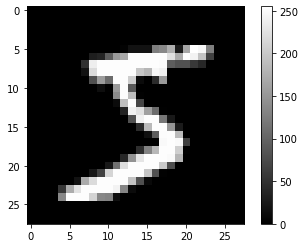

In [ ]:
plt.imshow(train_DS.data[0], cmap = 'gray')
plt.colorbar()

In [ ]:
print(train_DS.targets[0])

tensor(5)


## DataLoader 구경

In [ ]:
# SGD를 위하기 전 섞어주기
BATCH_SIZE = 32
train_DL = torch.utils.data.DataLoader(train_DS, batch_size = BATCH_SIZE, shuffle = True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size = BATCH_SIZE, shuffle=True)

In [ ]:
train_DL.dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([32, 1, 28, 28])
torch.uint8
torch.float32


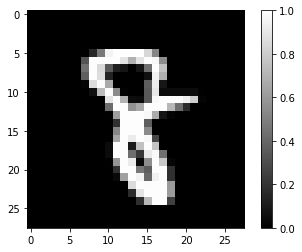

In [ ]:
x_batch, y_batch = next(iter(train_DL)) # 데이터 한 국자를 떠보기 (꺼내면서 transform 함수도 통과시킴)

print(type(train_DS.data))
print(type(x_batch))
print(x_batch.shape) # 개x채x행x렬 (28,28 사이즈의 1채널을 가진 사진이 32장 있음)
plt.imshow(x_batch[0].squeeze(), cmap = 'gray')
plt.colorbar() # to tensor 중 (0과 1사이의 값으로 바꿔줌)

print(train_DL.dataset.data.dtype)
print(x_batch.dtype)
# toTensor 역할
# 1. tensor로 바꿔준다
# 2. 개채행열로 바꿔준다
# 3. 0~1 사이로 바꿔준다 (int -> float)

## 본격적으로 model만들기

In [ ]:
from torch import nn

class MLP(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear = nn.Sequential(nn.Linear(28*28, 100), # 개x채 형태로 넣어야하니까 개: 32, 채: 1x28x28로 인식하도록 해서 28x28을 넣어줌
                                nn.ReLU(),
                                nn.Linear(100, 10)) # 노드를 10개로 빼줌 (총 개수가 10개로 분류)
    
  def forward(self, x):
      x = torch.flatten(x, start_dim=1)
      x = self.linear(x)
      return x

In [ ]:
# flatten 확인
x_batch, _ = next(iter(train_DL))
print(x_batch.shape)

flat_images = torch.flatten(x_batch) # 1d로 한번에 쫙펴버림
print(flat_images.shape)

flat_images2 = torch.flatten(x_batch, start_dim=1) # 펼치는 곳 위치를 정해줌
print(flat_images2.shape)

torch.Size([32, 1, 28, 28])
torch.Size([25088])
torch.Size([32, 784])


In [ ]:
model = MLP()
print(model)
x_batch, _ = next(iter(train_DL))
print(model(x_batch).shape)

MLP(
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
torch.Size([32, 10])


In [ ]:
from torch import optim

LR = 1e-3
EPOCH = 5 
criterion = nn.CrossEntropyLoss() 

def Train(model, train_DL, criterion, optimizer):

    loss_history = []
    NoT = len(train_DL.dataset)

    model.train() # train mode로 전환
    for ep in range(EPOCH):
        rloss = 0 # running loss
        for x_batch, y_batch in train_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            # inference
            y_hat = model(x_batch)
            # loss
            loss = criterion(y_hat, y_batch)
            # update
            optimizer.zero_grad() # gradient 누적을 막기 위한 초기화
            loss.backward() # backpropagation
            optimizer.step() # weight update

            #loss accumulation
            loss_b = loss.item()*x_batch.shape[0] #batch loss # BATCH_SIZE를 곱하면 마지막 18개도 32개를 곱하니까..
            rloss += loss_b #running loss
        # print loss
        loss_e = rloss/NoT # 
        loss_history += [loss_e]
        print(f"Epoch: {ep+1}, train loss: {round(loss.item(),3)}")
        print("-"*20)

    return loss_history

## Cross Entropy 확인 (왜 모델에 softmax를 안붙였을까?)

In [ ]:
# cross entropy 구하는 여러가지 방법
import torch.nn.functional as F

y_hat = torch.randn(3, 5) # data는 세 개, 5 종류로 분류하는 문제 가정
print(y_hat) # 가로 축으로 합이 1이 아님, 즉, softmax 통과 전
y_batch = torch.randint(5, (3,)) # 정답은 3개만 출련되므로 0~4중 3개를 출력
print(y_batch)

# 방법1
loss = F.cross_entropy(y_hat, y_batch) # softmax가 내장
print(loss)

# 방법2
criterion = nn.CrossEntropyLoss() # softmax가 내장 (방법3 과정이 안에 포함되어있음)
print(criterion(y_hat, y_batch))

# 방법3 (직접 구하기)
y_hat_soft = F.softmax(y_hat, dim=1)
print(y_hat_soft)
loss = 0
for i, val in enumerate(y_hat_soft):
    loss += -torch.log(val[y_batch[i]])
print(loss/3) # 평균이 내장되어있음을 알 수 있다

tensor([[ 0.3131,  0.7809, -0.6463, -1.6526,  0.3572],
        [-0.6978, -0.7878, -1.0368, -1.3582,  0.7726],
        [-0.3819,  0.3804,  0.4563,  0.0823,  0.5626]])
tensor([0, 1, 3])
tensor(1.7767)
tensor(1.7767)
tensor([[0.2401, 0.3833, 0.0920, 0.0336, 0.2509],
        [0.1334, 0.1220, 0.0951, 0.0689, 0.5806],
        [0.1040, 0.2228, 0.2404, 0.1654, 0.2674]])
tensor(1.7767)


## 모델 학습시키기

Epoch: 1, train loss: 0.288
--------------------
Epoch: 2, train loss: 0.076
--------------------
Epoch: 3, train loss: 0.239
--------------------
Epoch: 4, train loss: 0.166
--------------------
Epoch: 5, train loss: 0.04
--------------------


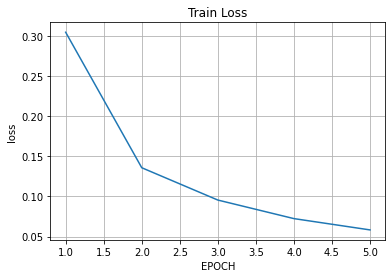

In [ ]:
model = MLP().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = LR)
loss_history = Train(model, train_DL, criterion, optimizer)

plt.plot(range(1,EPOCH+1),loss_history)
plt.xlabel("EPOCH")
plt.ylabel('loss')
plt.title('Train Loss')
plt.grid()

## 모델 저장하기 & 불러오기

In [ ]:
save_model_path = '/content/drive/MyDrive/파이토치 학습/result/MLP_MNIST'
torch.save(model.state_dict(), save_model_path)

In [ ]:
load_model = MLP().to(DEVICE)
load_model.load_state_dict(torch.load(save_model_path, map_location=DEVICE))
# map_location 있어야 GPU로 학습했던 거 현재 device로 불러올 수 있음

<All keys matched successfully>

## 모델 테스트하기

In [ ]:
def Test(model, test_DL):
    model.eval() # test mode로 전환
    with torch.no_grad():
        rcorrect = 0
        for x_batch, y_batch in test_DL: # gpu 통과될때 한국자씩 떠서 주기(용량때문에)
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            #inference
            y_hat = model(x_batch)
            pred = y_hat.argmax(dim = 1)

            # 맞춘개수, accumulation
            corrects_b = torch.sum(pred==y_batch).item()
            rcorrect += corrects_b # 누적
        accuracy_e = rcorrect/len(test_DL.dataset)*100
    print(f"Test accuracy: {rcorrect}/{len(test_DL.dataset)} ({round(accuracy_e,1)} %)")
    return round(accuracy_e, 1)

In [ ]:
Test(load_model, test_DL)

Test accuracy: 9721/10000 (97.2 %)


97.2

In [ ]:
def Test_plot(model, test_DL):
    model.eval()
    with torch.no_grad():
        x_batch, y_batch = next(iter(test_DL))
        x_batch = x_batch.to(DEVICE)
        y_hat = model(x_batch)
        pred = y_hat.argmax(dim=1)

    x_batch = x_batch.to("cpu") # gpu상태에서는 imshow가 안되서 cpu로 변경 필요

    plt.figure(figsize=(8,4))
    for idx in range(6):
        plt.subplot(2,3, idx+1, xticks=[], yticks=[])
        plt.imshow(x_batch[idx].permute(1,2,0).squeeze(), cmap="gray")
        pred_class = test_DL.dataset.classes[pred[idx]]
        true_class = test_DL.dataset.classes[y_batch[idx]]
        plt.title(f"{pred_class} ({true_class})", color = "g" if pred_class==true_class else "r") 

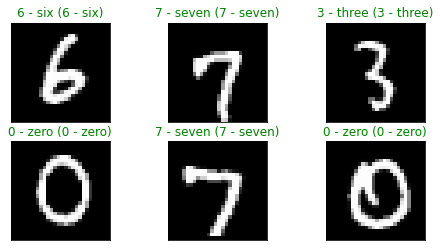

In [ ]:
Test_plot(load_model, test_DL)

In [ ]:
# 파라미터 수 구하기
def count_params(model):
    num = sum([p.numel() for p in model.parameters() if p.requires_grad])
    return num

In [ ]:
print(count_params(load_model))

79510
